# General Dependencies

In [1]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [2]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [3]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.2
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

14:34:24 INFO    1442971115.py:12: WORKING!


# Setup

In [4]:
from time import sleep

from core.controllers.steam import SteamController

ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")


In [5]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

c:\Users\magod\anaconda3\envs\env_uma\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
d:\GitHub\UmAutoplay\core\perception\ocr\ocr_local.py:88: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  self.reader = PaddleOCR(device=self.device, enable_hpi=False, **init_kwargs)
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddle

14:34:54 INFO    ocr_local.py:129: OCRInterface initialized | lang=en device=cpu


In [7]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(ctrl=ctrl)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

14:35:37 INFO    yolo_local.py:30: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma.pt


# Lookup

In [9]:
param_imgsz, param_conf, param_iou

(832, 0.2, 0.45)

14:38:54 DEBUG   197884194.py:56: Screen Detection: Unknown | {'training_buttons': 0, 'tazuna': False, 'infirmary': False, 'rest': False, 'rest_summer': False, 'recreation': False, 'race_day': False, 'counts': {'button_green': 1, 'button_white': 1}}


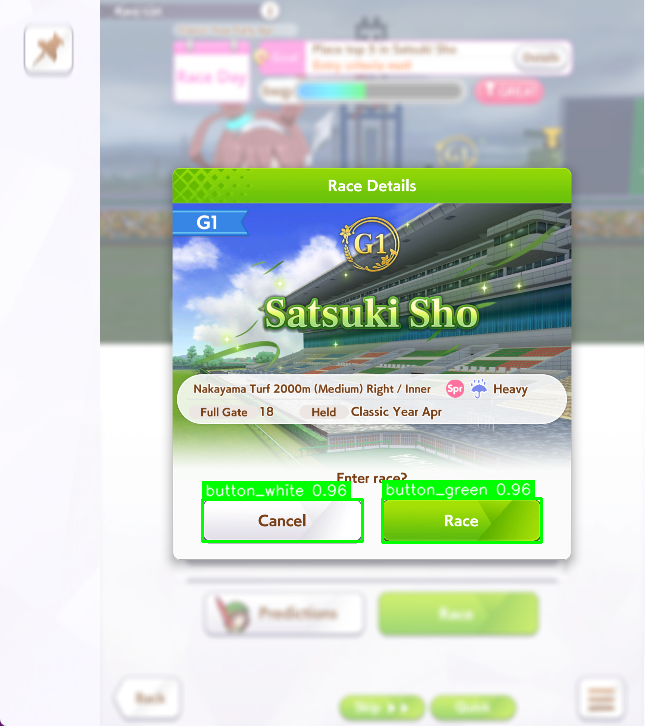

00 | button_green         | conf=0.962 | xyxy=(382.0,499.0,541.6,542.2)
01 | button_white         | conf=0.962 | xyxy=(202.9,499.6,362.5,541.9)


In [10]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np

def overlay_dets_to_bgr(pil_img, dets, *, box_color=(0, 255, 0), text_color=(255, 255, 255)):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), box_color, 2)

        # label bg
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), box_color, -1)
        cv2.putText(bgr, label, (x1 + 3, by1 + th + 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    return bgr

# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=param_conf,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


In [11]:
parsed_objects_screen

[{'idx': 0,
  'name': 'button_green',
  'conf': 0.9623947739601135,
  'xyxy': (382.0202941894531,
   498.9922790527344,
   541.5535888671875,
   542.2179565429688)},
 {'idx': 1,
  'name': 'button_white',
  'conf': 0.9623861312866211,
  'xyxy': (202.9427490234375,
   499.64373779296875,
   362.47137451171875,
   541.9152221679688)}]

# Segment by segment testing

## Others

In [46]:
# core/actions/race.py
from __future__ import annotations

import random
import time
from core.utils.waiter import Waiter
from typing import Dict, List, Tuple
from core.utils.race_index import RaceIndex

from PIL import Image

from core.controllers.base import IController
from core.perception.analyzers.badge import BADGE_PRIORITY, BADGE_PRIORITY_REVERSE, _badge_label
from core.perception.is_button_active import ActiveButtonClassifier
from core.settings import Settings
from core.types import DetectionDict
from core.utils.geometry import crop_pil
from core.utils.logger import logger_uma
from core.utils.text import _normalize_ocr
from core.utils.yolo_objects import collect, find, bottom_most, inside
from core.utils.pointer import smart_scroll_small


class RaceFlow:
    """
    Clean, modular Race flow:
      - One Waiter instance (no ad-hoc loops for waiting)
      - YOLO helpers & pointer utilities are reused
      - OCR is used only when texts=... is provided
    """

    def __init__(self, ctrl: IController, ocr, waiter: Waiter) -> None:
        self.ctrl = ctrl
        self.ocr = ocr
        self.waiter = waiter
    # --------------------------
    # Internal helpers
    # --------------------------
    def _collect(self, tag: str) -> Tuple[Image.Image, List[DetectionDict]]:
        return collect(self.ctrl, imgsz=self.waiter.cfg.imgsz, conf=self.waiter.cfg.conf, iou=self.waiter.cfg.iou, tag=tag)

    def _pick_view_results_button(self) -> Optional[DetectionDict]:
        """Among white buttons, choose the one that OCR-matches 'VIEW RESULTS' best."""
        img, dets = self._collect("race_view_btn")
        whites = find(dets, "button_white")
        if not whites:
            return None

        best_d, best_s = None, 0.0
        for d in whites:
            txt = (self.ocr.text(crop_pil(img, d["xyxy"])) or "").strip()
            score = max(fuzzy_ratio(txt, "VIEW RESULTS"), fuzzy_ratio(txt, "VIEW RESULT"))
            if score > best_s:
                best_d, best_s = d, score
        return best_d

    def _pick_race_square(
        self,
        *,
        prioritize_g1: bool,
        is_g1_goal: bool,
        desired_race_name: Optional[str] = None,
        max_scrolls: int = 3,
        date_key: Optional[str] = None,
    ) -> Tuple[Optional[DetectionDict], bool]:
        """
        Try to find a clickable race card:
          - consider 'race_square'
          - valid if it has >= 2 'race_star'
          - badge via color→OCR fallback
          - prioritize first G1 if requested; else EX>G1>G2>G3>OP (tie: topmost)
          - if desired_race_name is provided → do a one-way forward search for that name;
            if not found after scrolling up to max_scrolls, return (None, True) without fallback.

        """
        MINIMUM_RACE_OCR_MATCH = 0.85
        MIN_STARS = 2
        moved_cursor = False
        did_scroll = False
        first_top_xyxy = None

        best_non_g1: Optional[DetectionDict] = None
        best_rank: int = -1
        best_y: float = 1e9
        best_named: Optional[Tuple[DetectionDict, float]] = None  # (det, score)

        # Pre-compute the expected card titles and required rank for the desired race
        expected_cards: List[Tuple[str, str]] = []
        desired_order: int = 1
        seek_title: Optional[str] = None
        seek_rank: Optional[str] = None
        if desired_race_name:
            if date_key:
                e = RaceIndex.entry_for_name_on_date(desired_race_name, date_key)
                if e:
                    seek_title = str(e.get("display_title") or "").strip()
                    seek_rank  = str(e.get("rank") or "").strip().upper() or "UNK"
                    desired_order = int(e.get("order", 1)) if str(e.get("order", 1)).isdigit() else 1
                    expected_cards = [(seek_title, seek_rank)]
                    logger_uma.info("[race] Seeking '%s' on %s → title='%s', rank=%s, order=%d",
                                    desired_race_name, date_key, seek_title, seek_rank, desired_order)
            if not expected_cards:
                # fallback: not date-bound, use all occurrences
                expected_cards = RaceIndex.expected_titles_for_race(desired_race_name)
                logger_uma.info("[race] Seeking '%s' (no date binding) with titles: %s",
                                desired_race_name, [t for t, _ in expected_cards])
            if not expected_cards:
                # ultimate fallback to literal text
                expected_cards = [(desired_race_name.strip(), "UNK")]
                logger_uma.warning("[race] Dataset has no entries for '%s'; falling back to literal name.",
                                   desired_race_name)

        # collision tracking (how many times we’ve already seen the same display_title)
        seen_title_counts: Dict[str, int] = {}

        for scroll_j in range(max_scrolls + 1):
            game_img, dets = self._collect("race_pick")
            squares = find(dets, "race_square")
            if squares:
                # top→bottom

                squares.sort(key=lambda d: ((d["xyxy"][1] + d["xyxy"][3]) / 2.0))
                if first_top_xyxy is None:
                    first_top_xyxy = tuple(squares[0]["xyxy"])

                stars = find(dets, "race_star")
                badges = find(dets, "race_badge")

                if len(squares) == 1 and scroll_j == 0:
                    # Only one available race, doesn't matter star, choose it (e.g. Haru Urara Arima Kinen or Goal race without race aptitude due to lack of good sparks)
                    sq = squares[0]
                    need_click = True
                    if (not did_scroll) and first_top_xyxy is not None and tuple(sq["xyxy"]) == first_top_xyxy:
                        need_click = False
                    return sq, need_click
                
                # --- Optional: desired race search using dataset-built card title (right-of-badge OCR) ---
                if desired_race_name:
                    found_order = False
                    # Local best on this page — helps avoid scrolling past a good match
                    page_best: Optional[Tuple[DetectionDict, float]] = None
                    for idx_on_page, sq in enumerate(squares):
                        # minimum quality gate: at least 2 stars inside the square
                        s_cnt = sum(1 for st in stars if inside(st["xyxy"], sq["xyxy"], pad=3))
                        # if s_cnt < MIN_STARS:  # No stars in  desired race
                        #     continue

                        # badge (for rank validation) + OCR area: from badge right edge to square end
                        badge_det = next((b for b in badges if inside(b["xyxy"], sq["xyxy"], pad=3)), None)
                        badge_label = "UNK"
                        right_of_badge_xyxy = None
                        if badge_det is not None:
                            badge_label = _badge_label(self.ocr, game_img, badge_det["xyxy"])
                            bx1, by1, bx2, by2 = badge_det["xyxy"]
                            sx1, sy1, sx2, sy2 = sq["xyxy"]
                            badge_height = abs(by2 - by1)
                            padding = int(badge_height * 0.6)
                            right_of_badge_xyxy = (
                                bx2 + 1,
                                sy1 + padding,
                                sx2 - 6,
                                by2 + padding
                            )
                        else:
                            # conservative crop: right 70% of the square
                            sx1, sy1, sx2, sy2 = sq["xyxy"]
                            w = sx2 - sx1
                            right_of_badge_xyxy = (sx1 + int(0.30 * w), sy1 + 2, sx2 - 6, sy2 - 2)

                        try:
                            crop = crop_pil(game_img, right_of_badge_xyxy, pad=0)
                            txt = (self.ocr.text(crop) or "").strip()
                        except Exception:
                            txt = ""

                        best_score_here = 0

                        txt_split = txt.split(" ")
                        # try to look for 'perfect' match:
                        if len(expected_cards) == 1 and len(txt_split) >= 4:
                            expected_title, expected_rank = expected_cards[0]
                            txt_like_built = f"{txt_split[0]} {txt_split[1]} {txt_split[2]} {txt_split[3].strip()}".upper()

                            if (
                                badge_label.upper() == expected_rank.upper()
                                and txt_like_built == expected_title.upper()
                            ):
                                # Perfect match
                                best_score_here = 2
                        
                        if best_score_here == 0:
                            def clean_race_name(st):
                                n_txt = (
                                    st
                                    .upper()
                                    .replace("RIGHT", "")
                                    .replace("TURT", "TURF")
                                    .replace("DIRF", "DIRT")
                                    .replace("LEFT", "")
                                    .replace("INNER", "")
                                    .replace("1NNER", "")
                                    .replace("OUTER", "")
                                    .replace("/", "")
                                    .strip()  # TODO: handle right | left | etc
                                )
                                n_txt = _normalize_ocr(n_txt)
                                return n_txt
                            txt = clean_race_name(txt)

                            # If not 'perfect match' try fuzzy heuristic
                            # score against any of the expected cards; boost if badge matches rank
                            for expected_title, expected_rank in expected_cards:
                                expected_title_n = clean_race_name(expected_title)
                                s = fuzzy_ratio(txt, expected_title_n.upper())
                                if expected_rank in ("G1","G2","G3","OP","EX"):
                                    if badge_label.upper() == expected_rank.upper():
                                        s += 0.10  # reward correct badge
                                    elif badge_label != "UNK":
                                        s -= 0.20  # penalty for wrong badge
                                best_score_here = max(best_score_here, s)
                                logger_uma.debug(f"Score: {s} for 'txt'={txt} vs expected_title_n='{expected_title_n}'")

                        if best_named is None or best_score_here > best_named[1]:
                            best_named = (sq, best_score_here)
                        if (page_best is None) or (best_score_here > page_best[1]):
                            page_best = (sq, best_score_here)

                        # --- collision/order handling ---
                        # If we have a date-bound target with a known display_title, use order gating.
                        if seek_title:
                            # consider it a match only if title is close enough and badge ok
                            if best_score_here >= MINIMUM_RACE_OCR_MATCH:
                                cnt = seen_title_counts.get(seek_title, 0) + 1
                                seen_title_counts[seek_title] = cnt
                                logger_uma.info("[race] '%s' candidate #%d on page (idx=%d, score=%.2f, badge=%s, desired_order=%d)",
                                                seek_title, cnt, idx_on_page, best_score_here, badge_label, desired_order)
                                if cnt == desired_order:
                                    # pick this one — it is the N-th appearance of the title
                                    pick = sq
                                    ymid = (pick["xyxy"][1] + pick["xyxy"][3]) / 2.0
                                    need_click = True
                                    if (not did_scroll) and first_top_xyxy is not None and tuple(pick["xyxy"]) == first_top_xyxy:
                                        need_click = False
                                    logger_uma.info("[race] picked desired '%s' at required order=%d (y=%.1f)",
                                                    desired_race_name, desired_order, ymid)
                                    found_order = True
                                    return pick, need_click

                    # lock if we are reasonably sure on current page
                    if found_order and page_best and page_best[1] >= MINIMUM_RACE_OCR_MATCH:
                        pick = page_best[0]
                        ymid = (pick["xyxy"][1] + pick["xyxy"][3]) / 2.0
                        logger_uma.info("[race] picked desired '%s' by card-title (score=%.2f) at y=%.1f",
                                        desired_race_name, page_best[1], ymid)
                        need_click = True
                        if (not did_scroll) and first_top_xyxy is not None and tuple(pick["xyxy"]) == first_top_xyxy:
                            need_click = False
                        return pick, need_click
                else:
                    for sq in squares:
                        s_cnt = sum(1 for st in stars if inside(st["xyxy"], sq["xyxy"], pad=3))
                        if s_cnt < MIN_STARS:
                            continue

                        badge_det = next((b for b in badges if inside(b["xyxy"], sq["xyxy"], pad=3)), None)
                        label = "UNK"
                        if badge_det is not None:
                            label = _badge_label(self.ocr, game_img, badge_det["xyxy"])
                        rank = BADGE_PRIORITY.get(label, 0)
                        ymid = (sq["xyxy"][1] + sq["xyxy"][3]) / 2.0

                        if prioritize_g1 or is_g1_goal:
                            if label == "G1":
                                logger_uma.info("[race] picked G1 with 2★ at y=%.1f", ymid)
                                need_click = True
                                if (not did_scroll) and first_top_xyxy is not None and tuple(sq["xyxy"]) == first_top_xyxy:
                                    need_click = False
                                return sq, need_click
                            # if not is_g1_goal:
                            #     if rank > best_rank or (rank == best_rank and ymid < best_y):
                            #         best_non_g1, best_rank, best_y = sq, rank, ymid
                        else:
                            if is_g1_goal:
                                continue
                            if best_non_g1 is None:
                                best_non_g1, best_rank, best_y = sq, rank, ymid
                            else:
                                if (rank > best_rank) or (rank == best_rank and ymid < best_y):
                                    best_non_g1, best_rank, best_y = sq, rank, ymid

            if best_non_g1 is not None:
                logger_uma.info(
                    f"[race] Picked best race found, rank={BADGE_PRIORITY_REVERSE[best_rank]}"
                    
                )
                need_click = True
                if (not did_scroll) and first_top_xyxy is not None and tuple(best_non_g1["xyxy"]) == first_top_xyxy:
                    need_click = False
                return best_non_g1, need_click

            if squares and not moved_cursor:
                self.ctrl.move_xyxy_center(squares[0]["xyxy"])
                time.sleep(0.10)
                moved_cursor = True

            # probe next batch
            smart_scroll_small(self.ctrl, steps_pc=4)
            did_scroll = True
            time.sleep(0.35)

        if best_non_g1 is not None:
            # end-of-scroll fallback is always a click
            return best_non_g1, True
        return None, True

    # --------------------------
    # Public API
    # --------------------------
    def lobby(self) -> bool:
        """
        Handles the lobby where 'View Results' (white) and 'Race' (green) appear.
        Uses the unified Waiter API; no external polling loops.
        """
        # Try resolving 'View Results' and whether it is active
        view_btn = self._pick_view_results_button()
        if view_btn is None:
            # try again just in case
            time.sleep(1.5)
            view_btn = self._pick_view_results_button()

        is_view_active = False
        if view_btn is not None:
            clf = ActiveButtonClassifier.load(Settings.IS_BUTTON_ACTIVE_CLF_PATH)
            img, _ = self._collect("race_lobby_active")
            crop = crop_pil(img, view_btn["xyxy"])
            try:
                p = float(clf.predict_proba(crop))
                is_view_active = (p >= 0.51)
                logger_uma.debug("[race] View Results active probability: %.3f", p)
            except Exception:
                is_view_active = False

        if is_view_active and view_btn is not None:
            # Tap 'View Results' a couple times to clear residual screens
            self.ctrl.click_xyxy_center(view_btn["xyxy"], clicks=random.randint(2, 3))
            time.sleep(random.uniform(1.8, 2.6))
            self.ctrl.click_xyxy_center(view_btn["xyxy"], clicks=random.randint(2, 4))
            time.sleep(random.uniform(0.2, 0.3))
        else:
            # Click green 'RACE' (prefer bottom-most; OCR disambiguation if needed)
            self.waiter.click_when(
                classes=("button_green",),
                texts=("RACE",),
                prefer_bottom=True,
                timeout_s=3,
                tag="race_lobby_race_click",
            )
            time.sleep(11)
            # Extra confirm (popup) — one more greedy attempt
            self.waiter.click_when(
                classes=("button_green",),
                texts=("RACE",),
                prefer_bottom=True,
                timeout_s=4,
                tag="race_lobby_race_confirm",
            )

            for _ in range(5):
                # Press multiple skips buttons
                if self.waiter.click_when(classes=("button_skip",), prefer_bottom=True, timeout_s=2, tag="race_skip1"):
                    img, dets = self._collect("race_skip_followup")
                    sk = bottom_most(find(dets, "button_skip"))
                    if sk:
                        self.ctrl.click_xyxy_center(sk["xyxy"], clicks=random.randint(3, 5))
                time.sleep(0.3)

            logger_uma.debug("[race] Looking for CLOSE button.")
            self.waiter.click_when(
                classes=("button_white",),
                texts=("CLOSE",),
                prefer_bottom=False,
                allow_greedy_click=False,
                timeout_s=10,
                tag="race_trophy",
            )

        # Check if we loss


        if Settings.TRY_AGAIN_ON_FAILED_GOAL and self.waiter.click_when(
            classes=("button_green",),
            texts=("TRY AGAIN", ),
            prefer_bottom=False,
            allow_greedy_click=False,
            forbid_texts=("RACE", "NEXT"),
            timeout_s=2.0,
            clicks=1,
            tag="race_try_again",
        ):
            logger_uma.debug("[race] Lost the race, trying again.")
            # DANGER -> recursion:
            time.sleep(2)
            self.lobby()
        else:
            # After the race/UI flow → 'NEXT' / 'OK' / 'PROCEED'
            logger_uma.debug("[race] Looking for button_green 'Next' button. Shown after race.")
            self.waiter.click_when(
                classes=("button_green",),
                texts=("NEXT", ),
                prefer_bottom=True,
                timeout_s=1.2,
                clicks=random.randint(1, 2),
                tag="race_after_flow_next",
            )

            # 'Next' special
            logger_uma.debug("[race] Looking for race_after_next special button. When Pyramid")
            
            self.waiter.click_when(
                classes=("race_after_next",),
                texts=("NEXT", ),
                prefer_bottom=True,
                timeout_s=6.0,
                clicks=random.randint(2, 4),
                tag="race_after",
            )

            # Optional: Confirm 'Next'. TODO understand when to use
            # self.waiter.click_when(
            #     classes=("button_green",),
            #     texts=("NEXT", ),
            #     prefer_bottom=False,
            #     allow_greedy_click=False,
            #     timeout_s=2.0,
            #     tag="race_after",
            # )

            logger_uma.info("[race] RaceDay flow finished.")
            return True
    # --------------------------
    # Strategy selector (End / Late / Pace / Front)
    # --------------------------
    def set_strategy(self, select_style: str, *, timeout_s: float = 2.0) -> bool:
        """
        Pick a running style inside the 'Change Strategy' modal, then press Confirm.
        `select_style` must be one of: 'end', 'late', 'pace', 'front' (case-insensitive).
        Returns True if both clicks (style + confirm) were performed.
        """
        game_img, dets = self._collect("change_style")
        elements = find(dets, "button_change")
        if elements and len(elements) == 1:
            button_change = elements[0]
            self.ctrl.click_xyxy_center(button_change["xyxy"], clicks=1)
            time.sleep(0.5)
        else:
            return False
        select_style = (select_style or "").strip().lower()
        STYLE_ORDER = ["end", "late", "pace", "front"]  # left → right in the modal
        if select_style not in STYLE_ORDER:
            logger_uma.warning("[race] Unknown select_style=%r; defaulting to 'pace'", select_style)
            select_style = "front"

        # Read current modal
        img, dets = self._collect("change_style_modal")
        whites = find(dets, "button_white") or []
        greens = find(dets, "button_green") or []
        if not whites:
            logger_uma.error("[race] set_strategy: no white buttons detected.")
            return False

        # Confirm button: pick bottom-most green if present
        confirm_btn = bottom_most(greens)
        confirm_y1 = confirm_btn["xyxy"][1] if confirm_btn else float("inf")

        # Cancel button: bottom-most white (y center biggest)
        def y_center(d): 
            x1, y1, x2, y2 = d["xyxy"] 
            return 0.5 * (y1 + y2)
        cancel_btn = max(whites, key=y_center)

        # Candidate style buttons = white buttons above the confirm/cancel row
        style_btns = [d for d in whites if d is not cancel_btn and y_center(d) < (y_center(cancel_btn) - 10)]
        if not style_btns:
            # fall back: all whites except the bottom-most
            style_btns = [d for d in whites if d is not cancel_btn]

        # Sort left → right by x center
        style_btns.sort(key=lambda d: (0.5 * (d["xyxy"][0] + d["xyxy"][2])))

        # We *expect* the order to be End, Late, Pace, Front (when all present).
        # If fewer are present, try OCR to map; otherwise rely on left-right order.
        idx_map = {name: i for i, name in enumerate(STYLE_ORDER)}

        chosen = None
        if len(style_btns) >= 4:
            chosen = style_btns[idx_map[select_style]]
        else:
            # OCR fallback for robustness on partial layouts
            def read_label(btn):
                x1, y1, x2, y2 = btn["xyxy"]
                # shrink a bit to avoid borders
                shrink = max(2, int(min(x2-x1, y2-y1) * 0.10))
                roi = (x1 + shrink, y1 + shrink, x2 - shrink, y2 - shrink)
                try:
                    t = (self.ocr.text(crop_pil(img, roi)) or "").strip().lower()
                except Exception:
                    t = ""
                return t

            best_btn, best_sc = None, 0.0
            for b in style_btns:
                t = read_label(b)
                # be permissive: compare against canonical label
                sc = fuzzy_ratio(t, select_style)
                if sc > best_sc:
                    best_sc, best_btn = sc, b
            # accept if somewhat confident; else fall back to order
            if best_btn is not None and best_sc >= 0.45:
                chosen = best_btn
            else:
                # fallback to the closest expected index available
                target_idx = idx_map[select_style]
                chosen = style_btns[min(target_idx, len(style_btns)-1)]

        # Click selected style
        self.ctrl.click_xyxy_center(chosen["xyxy"], clicks=1)
        time.sleep(0.15)

        # Click Confirm
        if confirm_btn is None:
            # try waiter on text if green wasn't detected
            clicked = self.waiter.click_when(
                classes=("button_green",),
                texts=("CONFIRM",),
                prefer_bottom=True,
                timeout_s=timeout_s,
                tag="race_style_confirm_text",
            )
            return bool(clicked)
        else:
            self.ctrl.click_xyxy_center(confirm_btn["xyxy"], clicks=1)
            time.sleep(0.15)
            return True

    def run(
        self,
        *,
        prioritize_g1: bool = False,
        is_g1_goal: bool = False,
        desired_race_name: Optional[str] = None,
        date_key: Optional[str] = None,
        select_style = None
    ) -> bool:
        """
        End-to-end race-day routine. Assumes you're already in the 'Raceday' flow.
        """
        logger_uma.info(
            "[race] RaceDay begin (prioritize_g1=%s, is_g1_goal=%s)",
            prioritize_g1, is_g1_goal
        )

        time.sleep(0.9)
        # 1) Pick race card; scroll if needed
        square, need_click = self._pick_race_square(
            prioritize_g1=prioritize_g1,
            is_g1_goal=is_g1_goal,
            desired_race_name=desired_race_name,
            max_scrolls=3,
            date_key=date_key
        )
        if square is None:
            return False

        # 2) Click the race square
        if need_click:
            self.ctrl.click_xyxy_center(square["xyxy"], clicks=1)
            time.sleep(0.2)

        # 3) Click green 'RACE' on the list (prefer bottom-most; OCR 'RACE' if needed)
        if not self.waiter.click_when(
            classes=("button_green",),
            texts=("RACE",),
            prefer_bottom=True,
            timeout_s=1,
            tag="race_list_race",
        ):
            logger_uma.warning("[race] couldn't find green 'Race' button (list).")
            return False

        time.sleep(0.7)  # give time to popup to appear
        # 4) Confirm 'Race' popup (green) — one extra greedy attempt
        self.waiter.click_when(
            classes=("button_green",),
            texts=("RACE",),
            prefer_bottom=True,
            timeout_s=2,
            tag="race_popup_confirm",
        )

        time.sleep(4)
        # 5) Proceed with lobby handling
        if select_style:  # front, pace, late, end
            self.set_strategy(select_style)
            time.sleep(4)

        return self.lobby()


In [ ]:
# race = RaceFlow(ctrl, ocr, waiter)
# race.set_strategy("front")
# time.sleep(4)
# race.lobby()

15:44:41 DEBUG   866917598.py:340: [race] View Results active probability: 1.000
15:44:49 DEBUG   waiter.py:137: [waiter] timeout after 2.00s (tag=race_try_again)
15:44:49 DEBUG   866917598.py:407: [race] Looking for button_green 'Next' button. Shown after race.
15:44:50 DEBUG   866917598.py:418: [race] Looking for race_after_next special button. When Pyramid
15:44:52 INFO    866917598.py:439: [race] RaceDay flow finished.


True

## Agent

In [ ]:
# core/agent.py
from __future__ import annotations


from core.actions.claw import ClawGame
from core.actions.events import click_top_event_choice
from core.actions.lobby import LobbyFlow
# from core.actions.race import RaceFlow
from core.actions.skills import auto_buy_skills
from core.actions.training_policy import (
    TrainAction,
    click_training_tile,
    check_training
)
from core.perception.detection import classify_screen
from core.perception.extractors.state import extract_goal_text, extract_skill_points, find_best
from core.perception.ocr import OCRInterface
# from core.settings import Settings
from core.utils.logger import logger_uma
from core.utils.waiter import PollConfig, Waiter


class Player:
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig = PollConfig(
            imgsz=Settings.YOLO_IMGSZ,
            conf=Settings.YOLO_CONF,
            iou=Settings.YOLO_IOU,
            poll_interval_s=0.5,
            timeout_s=4.0,
            tag="player",
        ),
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh = 3,
        select_style = None
    ) -> None:
        self.ctrl = ctrl
        self.ocr = ocr
        self.is_running = False
        self.imgsz = Settings.YOLO_IMGSZ
        self.conf = Settings.YOLO_CONF
        self.iou = Settings.YOLO_IOU
        self.prioritize_g1 = bool(prioritize_g1)
        self._skip_training_race_once = False
        self.plan_races = dict(plan_races or {})

        # Vision params used by Waiter & flows
        self.skill_list = skill_list or []

        self.auto_rest_minimum = auto_rest_minimum

        # Shared Waiter for the whole agent
        self.waiter = Waiter(self.ctrl, self.ocr, waiter_config)

        # Flows
        self.race = RaceFlow(self.ctrl, self.ocr, self.waiter)
        self.lobby = LobbyFlow(
            self.ctrl,
            self.ocr,
            self.waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            interval_stats_refresh=interval_stats_refresh,
            plan_races=self.plan_races,
        )
        self.claw_game = ClawGame(self.ctrl)
        self.claw_turn = 0

        self._iterations_turn = 0
        self._minimum_skill_pts = int(minimum_skill_pts)
        self.patience = 0
        self.select_style = select_style
    
    def _desired_race_today(self) -> str | None:
        """
        If we have a planned race for today's date (Y{year}-{MM}-{half}),
        return its name; otherwise None.
        """
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        key = f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"
        plan = getattr(self.lobby, "plan_races", None) or self.plan_races
        race = plan.get(key)
        if race:
            logger_uma.info(f"[agent] Planned race for {key}: {race}")
        return race

    def _today_date_key(self) -> Optional[str]:
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        return f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"

    # --------------------------
    # Main loop
    # --------------------------
    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        while self.is_running:
            sleep(delay)
            img, _, dets = recognize(self.ctrl,
                imgsz=self.imgsz, conf=self.conf, iou=self.iou, tag="screen"
            )

            screen, _ = classify_screen(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
                debug=True,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            if unknown_screen:
                threshold = 0.65
                if self.patience > 20 == 0:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=("button_green", "race_after_next", "button_white"),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning("Stopping the algorithm just for safeness, nothing happened in 20 iterations")
                        self.is_running = False
                        break
                continue

            if screen == "Event":
                self.claw_turn = 0
                click_top_event_choice(self.ctrl, self.ocr, dets, conf_min=0.6)
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                inspiration = find_best(dets, "event_inspiration", conf_min=0.4)
                if inspiration:
                    self.ctrl.click_xyxy_center(inspiration["xyxy"], clicks=1)
                continue

            if screen == "Raceday":
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}")

                # If enough points, go to skills and auto-buy (unchanged logic)
                if self.lobby.state.skill_pts >= self._minimum_skill_pts and len(self.skill_list) > 0:
                    self.lobby._go_skills()
                    bought = auto_buy_skills(
                        self.ctrl,
                        self.ocr,
                        skill_list=self.skill_list,
                        imgsz=self.imgsz,
                        conf=self.conf,
                        iou=self.iou,
                    )
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                career_date_raw = (self.lobby.state.career_date_raw or "")

                race_predebut = 'predebut' in career_date_raw.lower().replace("-", "")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = extract_goal_text(self.ocr, img, dets) or ""

                    race_predebut = ("junior make debut" in self.lobby.state.goal.lower())

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    self.lobby._go_race(reason="Clicking race (race day)...")
                    if not self.race.run(prioritize_g1=False, select_style=self.select_style):  # select whatever is in the goal
                        raise RuntimeError("Couldn't race")
                    continue
                else:
                    # Enter or confirm race, then run RaceFlow
                    self.lobby._go_race(reason="Clicking race (race day)...")
                    if not self.race.run(prioritize_g1=False, select_style=None):  # select whatever is in the goal
                        raise RuntimeError("Couldn't race")
                    continue


            if screen == "Lobby" or is_lobby_summer:
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        if self.lobby._go_race(reason=self.lobby.state.goal):
                            ok = self.race.run(prioritize_g1=True, is_g1_goal=True)
                            if not ok:
                                logger_uma.error("[lobby] Couldn't race (G1 target). Backing out; set skip guard.")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            ok = self.race.run(
                                prioritize_g1=self.prioritize_g1,
                                is_g1_goal=False,
                                desired_race_name=desired_race_name,
                                date_key=self._today_date_key(),
                            )
                            if not ok:
                                logger_uma.error(f"[race] Couldn't race {desired_race_name}")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.state.planned_race_name = None

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        if self.lobby._go_race(reason=self.lobby.state.goal):
                            ok = self.race.run(prioritize_g1=self.prioritize_g1, is_g1_goal=False)
                            if not ok:
                                logger_uma.error("[lobby] Couldn't race (fans target). Backing out; set skip guard.")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self._handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                if self.lobby._go_skills():
                    sleep(1.0)
                    bought = auto_buy_skills(
                        self.ctrl,
                        self.ocr,
                        skill_list=self.skill_list,
                        imgsz=self.imgsz,
                        conf=self.conf,
                        iou=self.iou,
                    )
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    self.is_running = False  # end of career
                    logger_uma.info("Detected end of career")
                    
                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue
            
            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}")
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def _handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx)
            if not ok:
                logger_uma.error("[training] Failed to click training tile idx=%s", tidx)
            return

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby
                if self.lobby._go_race(reason="Racing..."):
                    if self.race.run(prioritize_g1=self.prioritize_g1):
                        return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning("[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found).")
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                        click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    else:
                        logger_uma.info("[training] Second decision after failed race: %s", decision2.action.value)
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")



## RUN

In [ ]:
assert ctrl.focus()

player = Player(
    ctrl=ctrl,
    ocr=ocr,
    interval_stats_refresh=getattr(Settings, "CHECK_STATS_INTERVAL", 4),
    minimum_skill_pts=getattr(Settings, "MINIMUM_SKILL_PTS", 700),
    prioritize_g1=getattr(Settings, "PRIORITIZE_G1", False),
    auto_rest_minimum=26,
    plan_races = {
        "Y2-11-1": "Queen Elizabeth II Cup",
        "Y3-03-2": "Osaka Hai",
        "Y3-06-2": "Takarazuka Kinen",
        # "Y3-10-1": "Fuchu Umamusume Stakes",  # test ambiguity
        "Y3-10-2": "Tenno Sho (Autumn)",
    },
    select_style="front",
    skill_list=[
        "Concentration",
        "Focus",
        "Professor of Curvature",
        "Swinging Maestro",
        "Corner Recovery",
        "Corner Acceleration",
        "Straightaway Recovery",
        "Homestretch Haste",
        "Straightaway Acceleration",
        "Firm Conditions",
        "Front Runner Corners",
        "Front Runner Straightaways",
        "Front Runner Savvy",
        "Unrestrained"
    ]
)

player.run(
    delay=getattr(Settings, "MAIN_LOOP_DELAY", 0.4),
    max_iterations=getattr(Settings, "MAX_ITERATIONS", 300),
)

# SKILLs Frontend
skill_list=[
    "Concentration",
    "Focus",
    "Professor of Curvature",
    "Swinging Maestro",
    "Corner Recovery",
    "Corner Acceleration",
    "Straightaway Recovery",
    "Homestretch Haste",
    "Straightaway Acceleration",
    "Firm Conditions",
    "Front Runner Corners",
    "Front Runner Straightaways",
    "Front Runner Savvy",
    "Unrestrained"
]

# SKILLs Pace
skill_list=[
    "Concentration",
    "Focus",
    "Professor of Curvature",
    "Corner Adept",
    "Swinging Maestro",
    "Corner Recovery",
    "Corner Acceleration",
    "Straightaway Recovery",
    "Homestretch Haste",
    "Straightaway Acceleration",
    "Firm Conditions",
    "Pace Chaser Corners",
    "Pace Chaser Straightaways",
    "Pace Chaser Savvy",
    "Slipstream"
]

# RACES for Mihono
plan_races = {
    "Y2-11-1": "Queen Elizabeth II Cup",
    "Y3-03-2": "Osaka Hai",
    "Y3-06-2": "Takarazuka Kinen",
    "Y3-10-2": "Tenno Sho (Autumn)",
}

# RACES McQueen
plan_races = {
    "Y1-12-2": "Hopeful Stakes",
    "Y2-04-1": "Satsuki Sho",
    "Y2-05-2": "Tokyo Yushun (Japanese Derby)",
    "Y3-03-2": "Osaka Hai",
    "Y3-11-2": "Japan Cup",
    "Y3-12-2": "Arima Kinen",
}

# RACES Daiwa
plan_races = {
    "Y1-12-1": "Asahi Hai Futurity Stakes",
    "Y2-05-1": "NHK Mile Cup",
    "Y3-05-1": "Victoria Mile",
    "Y3-06-2": "Takarazuka Kinen",
    "Y3-11-2": "Japan Cup",
}

15:46:37 DEBUG   lobby.py:406: [date] prev: None. Cand: DateInfo(raw='Junior Year Early Jul', year_code=1, month=7, half=1). accepted: DateInfo(raw='Junior Year Early Jul', year_code=1, month=7, half=1)
15:46:37 INFO    lobby.py:407: [date] initial: None -> Y1-Jul-1
15:46:37 INFO    lobby.py:124: Date: DateInfo(raw='Junior Year Early Jul', year_code=1, month=7, half=1) | raw: Junior Year Early Jul
15:46:38 INFO    lobby.py:568: [lobby] No critical actions → go Train
15:46:38 DEBUG   state.py:246: Stat 17 < 90 without trailing letter; clamping to 90 (raw='17')
15:46:38 INFO    lobby.py:297: [stats] update: SPD:-1->217, STA:-1->204, GUTS:-1->102, WIT:-1->106
15:46:38 INFO    4101616940.py:290: [lobby] goal='Q Goal Place top 5 in Asahi Hai F.S. Details Entry criteria met!' | energy=29 | skill_pts=0 | turn=10 | summer=False | mood=('NORMAL', 3) | stats={'SPD': 217, 'STA': 204, 'PWR': -1, 'GUTS': 102, 'WIT': 106} |
15:46:43 INFO    training_policy.py:779: View SPD: SV=2.00  fail=42% (≤ 20% 

KeyboardInterrupt: 

# END